# Safety Car Prediction

https://medium.com/formula-one-forever/formula-1-data-analysis-with-fastf1-%EF%B8%8F-d451b30f3a91

In [1]:
!pip install fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import fastf1

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colormaps
from matplotlib.collections import LineCollection
import fastf1.plotting

In [3]:
!pip install scikit-learn


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = "/content/drive/MyDrive/f1_project/f1_merged_all_data.csv"

df = pd.read_csv(file_path)
print(len(df))
df = df.drop_duplicates()
print(len(df))

"""df["lap_bin"] = pd.cut(
    df["lap"],
    bins=range(0, df["lap"].max() + 6, 5),
    right=False
)"""

# create bins of 5 laps labeled bi1, bi2, bi3, ...
df["bins"] = "bin" + (((df["lap"] - 1) // 5) + 1).astype(str)


101297
6172


In [6]:
df["is_street_circuit_encoded"] = df["is_street_circuit"].map({
    True: 1,
    False: 0
})

encoded_df = pd.get_dummies(
    df,
    columns=["bins"],
    prefix="is",
    drop_first=True,
    dtype=int
)

encoded_df["is_safety_car"] = df["status_code"].isin([4, 6]).astype(int)

In [7]:
encoded_df[['is_safety_car']]

,is_safety_car
0,0
1,0
2,0
3,0
4,0
...,...
100194,0
100195,0
100196,0
100197,0


In [8]:
save_path = "/content/drive/MyDrive/f1_project/encoded_dataframe.csv"
encoded_df.to_csv(save_path, index=False)

In [9]:
"""create feature vector and find which features are less important"""

# extra features to enhance accuracy
# lap-based features
encoded_df['early_race'] = (encoded_df['lap'] < 5).astype(int)  # first lap incidents
encoded_df['mid_race'] = ((encoded_df['lap'] >= 5) & (encoded_df['lap'] <= 40)).astype(int)
encoded_df['late_race'] = (encoded_df['lap'] > 40).astype(int)

# weather risk features
encoded_df['wet_conditions'] = (encoded_df['Rainfall'] > 0).astype(int)
encoded_df['temp_change'] = encoded_df.groupby(['year', 'round'])['TrackTemp'].diff().fillna(0)
encoded_df['weather_risk'] = (
    (encoded_df['Rainfall'] > 0) |
    (encoded_df['Humidity'] > 80) |
    (encoded_df['WindSpeed'] > 20)
).astype(int)

# track danger features
encoded_df['high_risk_track'] = (
    (encoded_df['is_street_circuit'] == 1) &
    (encoded_df['corners'] > 15)
).astype(int)

# historical features (lag features - did previous lap have issues?)
encoded_df['prev_lap_sc'] = encoded_df.groupby(['year', 'round'])['is_safety_car'].shift(1).fillna(0)
encoded_df['prev_2lap_sc'] = encoded_df.groupby(['year', 'round'])['is_safety_car'].shift(2).fillna(0)

# dependent variable
y = encoded_df["is_safety_car"]

drop_cols = ["lap_number"]
X = encoded_df.drop(columns=[c for c in drop_cols if c in encoded_df.columns])
X = X.drop(columns=[c for c in X.columns if c.startswith("bin")])
X = X.fillna(X.mean())
X_original = X.copy()
safety_car_column = X['is_safety_car'].copy()
X = X.drop(columns=['is_safety_car'])

In [10]:
encoded_df

,year,round,lap,status_code,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,...,is_safety_car,early_race,mid_race,late_race,wet_conditions,temp_change,weather_risk,high_risk_track,prev_lap_sc,prev_2lap_sc
0,2022,1,1,1,23.617791,29.490798,1010.385890,0.0,28.610429,124.429448,...,0,1,0,0,0,0.0,0,0,0.0,0.0
1,2022,1,2,1,23.617791,29.490798,1010.385890,0.0,28.610429,124.429448,...,0,1,0,0,0,0.0,0,0,0.0,0.0
2,2022,1,3,1,23.617791,29.490798,1010.385890,0.0,28.610429,124.429448,...,0,1,0,0,0,0.0,0,0,0.0,0.0
3,2022,1,4,1,23.617791,29.490798,1010.385890,0.0,28.610429,124.429448,...,0,1,0,0,0,0.0,0,0,0.0,0.0
4,2022,1,5,1,23.617791,29.490798,1010.385890,0.0,28.610429,124.429448,...,0,0,1,0,0,0.0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100194,2025,24,54,1,26.674026,60.441558,1016.727922,0.0,31.061688,223.071429,...,0,0,0,1,0,0.0,0,0,0.0,0.0
100195,2025,24,55,1,26.674026,60.441558,1016.727922,0.0,31.061688,223.071429,...,0,0,0,1,0,0.0,0,0,0.0,0.0
100196,2025,24,56,1,26.674026,60.441558,1016.727922,0.0,31.061688,223.071429,...,0,0,0,1,0,0.0,0,0,0.0,0.0
100197,2025,24,57,1,26.674026,60.441558,1016.727922,0.0,31.061688,223.071429,...,0,0,0,1,0,0.0,0,0,0.0,0.0


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [12]:
print("FEATURE SELECTION: Finding Less Important Features")
print("="*70)

# train a quick logistic regression on full dataset
lr_temp = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    penalty='l1',  # L1 regularization helps with feature selection
    C=1.0
)

lr_temp.fit(X, y)

# get absolute coefficients (feature importance)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_temp.coef_[0],
    'abs_coefficient': np.abs(lr_temp.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print(feature_importance)

FEATURE SELECTION: Finding Less Important Features

Feature Importance (Logistic Regression Coefficients):
                      feature  coefficient  abs_coefficient
36                prev_lap_sc     4.059467         4.059467
19                   is_bin15    -2.800136         2.800136
29                 early_race     2.369511         2.369511
34               weather_risk    -2.244290         2.244290
32             wet_conditions     2.038393         2.038393
17                   is_bin13    -1.516185         1.516185
20                   is_bin16    -1.495957         1.495957
14                   is_bin10     0.935022         0.935022
31                  late_race    -0.905552         0.905552
15                   is_bin11     0.561536         0.561536
27                    is_bin8    -0.532230         0.532230
13  is_street_circuit_encoded     0.420859         0.420859
37               prev_2lap_sc    -0.376918         0.376918
35            high_risk_track    -0.367107         0.

In [13]:
#drop features with low coefficient (below threshold)
COEFFICIENT_THRESHOLD = 0.05  # Adjust this threshold
features_to_drop_B = feature_importance[feature_importance['abs_coefficient'] < COEFFICIENT_THRESHOLD]['feature'].tolist()

In [14]:
for feature in features_to_drop_B:
  X = X.drop(columns=[feature])

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

safety_car_train = safety_car_column.loc[X_train.index]
safety_car_test = safety_car_column.loc[X_test.index]

# calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}



In [ ]:
# regular code to find best threshold, not in use so i can compare difference in results with different thresholds
# calculate precision and recall for different thresholds
# precisions, recalls, thresholds = precision_recall_curve(y_test, predicted_probabilities)

# # optimize for F2 (emphasizes recall)


# beta = 0.5: Care more about precision (fewer false alarms)
# beta = 1.0: Equal balance (standard F1)
# beta = 2.0: Care more about recall (catch more safety cars)
# beta = 3.0: Heavily prioritize recall


# beta = 2.5
# f2_scores = (1 + beta**2) * (precisions[:-1] * recalls[:-1]) / (beta**2 * precisions[:-1] + recalls[:-1] + 1e-10)
# best_idx = np.argmax(f2_scores)
# best_threshold = thresholds[best_idx]

# # Use the optimal threshold
# predicted_labels = (predicted_probabilities > best_threshold).astype(int)

In [18]:
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

configurations = [
    {'weight': 5, 'smote_ratio': 0.2},
    {'weight': 8, 'smote_ratio': 0.3},
    {'weight': 10, 'smote_ratio': 0.3},
]

# initialize best tracking variables before the loop
best_f2 = 0
best_config = None
best_model = None
best_threshold = 0.5
best_probabilities = None

for config in configurations:
    print(f"\n{'='*70}")
    print(f"Configuration: Weight={config['weight']}, SMOTE={config['smote_ratio']}")
    print('='*70)

    # apply SMOTE to create synthetic safety car examples to oversample minority class
    smote = SMOTE(sampling_strategy=config['smote_ratio'], random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # train with class weights
    model = LogisticRegression(
        solver="liblinear",
        max_iter=1000,
        class_weight={0: 1, 1: config['weight']}
    )

    # train on resampled data
    model.fit(X_train_resampled, y_train_resampled)

    predicted_probabilities = model.predict_proba(X_test)[:, 1]

    print("\nModel Performance at Different Thresholds:")
    print("-" * 60)

    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
        predicted_labels = (predicted_probabilities > threshold).astype(int)

        tp = ((y_test == 1) & (predicted_labels == 1)).sum()
        fp = ((y_test == 0) & (predicted_labels == 1)).sum()
        fn = ((y_test == 1) & (predicted_labels == 0)).sum()
        tn = ((y_test == 0) & (predicted_labels == 0)).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        # calculate F2 score
        beta = 2.0
        f2 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0

        print(f"\nThreshold {threshold:.1f}:")
        print(f"  Caught {tp}/{tp+fn} safety cars ({recall:.1%} recall)")
        print(f"  {fp} false alarms ({precision:.1%} precision)")
        print(f"  F1 Score: {f1:.3f}")
        print(f"  F2 Score: {f2:.3f}")

        # track best configuration based on F2 score
        if f2 > best_f2:
            best_f2 = f2
            best_config = config
            best_model = model
            best_threshold = threshold
            best_probabilities = predicted_probabilities

# after the loop ends print best configuration
print(f"\n{'='*70}")
print("BEST CONFIGURATION FOUND:")
print('='*70)
print(f"Best Config: Weight={best_config['weight']}, SMOTE={best_config['smote_ratio']}")
print(f"Best Threshold: {best_threshold:.1f}")
print(f"Best F2 Score: {best_f2:.3f}")

# use best model predictions for final evaluation
predicted_labels = (best_probabilities > best_threshold).astype(int)

# calculate final metrics
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

# recalculate F2 for best configuration
beta = 2.0
f2_final = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0

print(f"\n{'='*70}")
print("FINAL MODEL PERFORMANCE:")
print('='*70)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1:.3f}")
print(f"F2 Score: {f2_final:.3f}")

# full classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, predicted_labels, target_names=['No Safety Car', 'Safety Car']))

# confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
print("\n--- Confusion Matrix ---")
print(f"True Negatives (correctly predicted no safety car): {cm[0, 0]}")
print(f"False Positives (incorrectly predicted safety car): {cm[0, 1]}")
print(f"False Negatives (missed safety cars): {cm[1, 0]}")
print(f"True Positives (correctly predicted safety car): {cm[1, 1]}")

# calculate specific accuracies
total_correct = cm[0, 0] + cm[1, 1]
total_predictions = cm.sum()
accuracy_manual = (total_correct / total_predictions) * 100
print(f"\nManual Accuracy Calculation: {accuracy_manual:.2f}%")

print(f"\n{'='*70}")
print("Summary: The model with Weight={}, SMOTE={} at threshold {} achieved the best F2 score of {:.3f}".format(
    best_config['weight'], best_config['smote_ratio'], best_threshold, best_f2))
print('='*70)



Configuration: Weight=5, SMOTE=0.2

Model Performance at Different Thresholds:
------------------------------------------------------------

Threshold 0.1:
  Caught 82/85 safety cars (96.5% recall)
  2066 false alarms (3.8% precision)
  F1 Score: 0.073
  F2 Score: 0.165

Threshold 0.2:
  Caught 72/85 safety cars (84.7% recall)
  1430 false alarms (4.8% precision)
  F1 Score: 0.091
  F2 Score: 0.195

Threshold 0.3:
  Caught 63/85 safety cars (74.1% recall)
  976 false alarms (6.1% precision)
  F1 Score: 0.112
  F2 Score: 0.228

Threshold 0.4:
  Caught 54/85 safety cars (63.5% recall)
  616 false alarms (8.1% precision)
  F1 Score: 0.143
  F2 Score: 0.267

Threshold 0.5:
  Caught 49/85 safety cars (57.6% recall)
  368 false alarms (11.8% precision)
  F1 Score: 0.195
  F2 Score: 0.324

Threshold 0.6:
  Caught 39/85 safety cars (45.9% recall)
  197 false alarms (16.5% precision)
  F1 Score: 0.243
  F2 Score: 0.339

Threshold 0.7:
  Caught 37/85 safety cars (43.5% recall)
  68 false alarms

In [19]:
# get predicted probabilities from the model
predicted_probabilities = model.predict_proba(X_test)[:, 1]

# create comparison dataframe using the probabilities you just calculated
comparison_df = pd.DataFrame({
    'actual': y_test,
    'predicted_probability': predicted_probabilities  # use the variable, not encoded_df column
})

print(comparison_df.head())

       actual  predicted_probability
40630       0               0.556439
99115       0               0.514568
63765       0               0.447855
55364       0               0.699753
59185       0               0.614397


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# overall Accuracy - percentage of ALL predictions that were correct
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

# more detailed metrics
print("\n--- Detailed Metrics ---")

# precision - of all predicted safety cars, how many were actually safety cars?
precision = precision_score(y_test, predicted_labels)
print(f"Precision: {precision * 100:.2f}%") #precision minimizes false positives

# recall - of all actual safety cars, how many did we catch?
recall = recall_score(y_test, predicted_labels)
print(f"Recall (Sensitivity): {recall * 100:.2f}%") #recall minimizes false negatives

# F1 Score - harmonic mean of precision and recall
print(f"F2-optimized threshold: {best_threshold:.3f}")

# full classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, predicted_labels, target_names=['No Safety Car', 'Safety Car']))

# confusion Matrix (more visual)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predicted_labels)
print("\n--- Confusion Matrix ---")
print(f"True Negatives (correctly predicted no safety car): {cm[0, 0]}")
print(f"False Positives (incorrectly predicted safety car): {cm[0, 1]}")
print(f"False Negatives (missed safety cars): {cm[1, 0]}")
print(f"True Positives (correctly predicted safety car): {cm[1, 1]}")

# calculate specific accuracies
total_correct = cm[0, 0] + cm[1, 1]
total_predictions = cm.sum()
accuracy_manual = (total_correct / total_predictions) * 100

Accuracy: 95.30%

--- Detailed Metrics ---
Precision: 35.24%
Recall (Sensitivity): 43.53%
F2-optimized threshold: 0.700

--- Classification Report ---
               precision    recall  f1-score   support

No Safety Car       0.98      0.97      0.98      2384
   Safety Car       0.35      0.44      0.39        85

     accuracy                           0.95      2469
    macro avg       0.67      0.70      0.68      2469
 weighted avg       0.96      0.95      0.96      2469


--- Confusion Matrix ---
True Negatives (correctly predicted no safety car): 2316
False Positives (incorrectly predicted safety car): 68
False Negatives (missed safety cars): 48
True Positives (correctly predicted safety car): 37


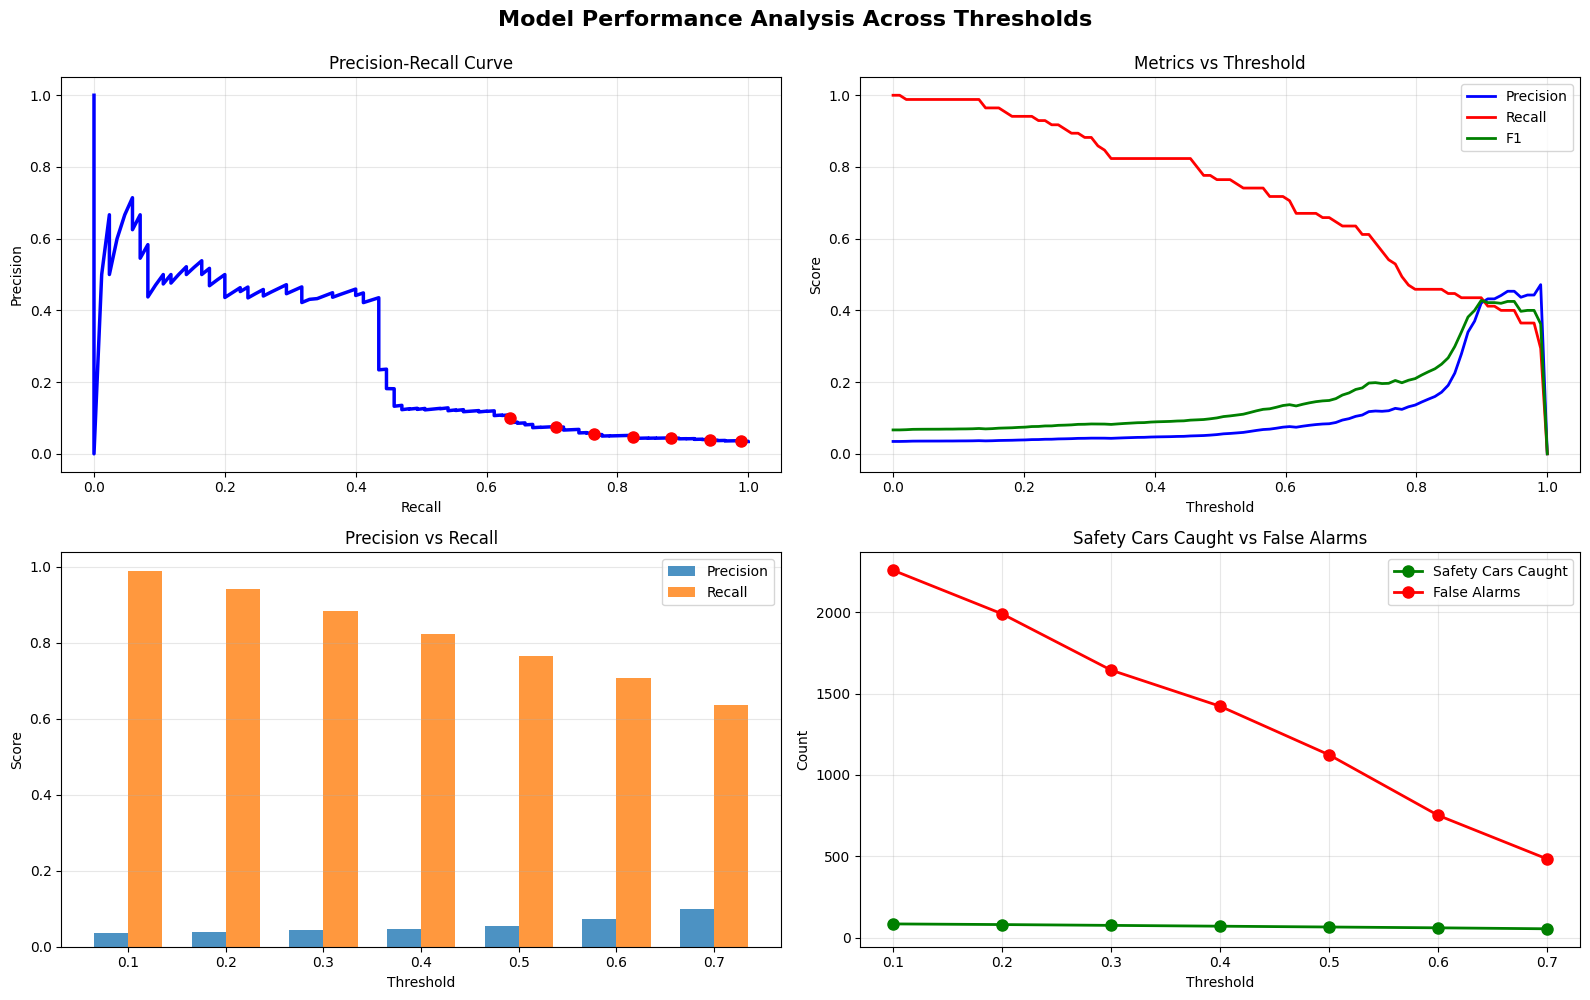

In [24]:
fig = plt.figure(figsize=(16, 10))

# mark specific thresholds
test_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
colors = ['red', 'orange', 'green', 'blue', 'purple']

# subplot 1: Precision-Recall Curve
ax1 = plt.subplot(2, 2, 1)
precisions, recalls, thresholds = precision_recall_curve(y_test, predicted_probabilities)
ax1.plot(recalls, precisions, 'b-', linewidth=2.5)
for i, thresh in enumerate(test_thresholds):
    idx = np.argmin(np.abs(thresholds - thresh))
    ax1.plot(recalls[idx], precisions[idx], 'ro', markersize=8)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.grid(True, alpha=0.3)


precisions, recalls, thresholds = precision_recall_curve(y_test, predicted_probabilities)


# subplot 2: Metrics vs Threshold
ax2 = plt.subplot(2, 2, 2)
thresholds_range = np.linspace(0, 1, 100)
precisions_list = []
recalls_list = []
f1_list = []

for thresh in thresholds_range:
    pred = (predicted_probabilities > thresh).astype(int)
    tp = ((y_test == 1) & (pred == 1)).sum()
    fp = ((y_test == 0) & (pred == 1)).sum()
    fn = ((y_test == 1) & (pred == 0)).sum()

    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0

    precisions_list.append(p)
    recalls_list.append(r)
    f1_list.append(f)

ax2.plot(thresholds_range, precisions_list, 'b-', linewidth=2, label='Precision')
ax2.plot(thresholds_range, recalls_list, 'r-', linewidth=2, label='Recall')
ax2.plot(thresholds_range, f1_list, 'g-', linewidth=2, label='F1')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Metrics vs Threshold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# subplot 3: Bar Comparison
ax3 = plt.subplot(2, 2, 3)
precisions_vals = []
recalls_vals = []

for thresh in test_thresholds:
    pred = (predicted_probabilities > thresh).astype(int)
    tp = ((y_test == 1) & (pred == 1)).sum()
    fp = ((y_test == 0) & (pred == 1)).sum()
    fn = ((y_test == 1) & (pred == 0)).sum()

    precisions_vals.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    recalls_vals.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

x = np.arange(len(test_thresholds))
width = 0.35
ax3.bar(x - width/2, precisions_vals, width, label='Precision', alpha=0.8)
ax3.bar(x + width/2, recalls_vals, width, label='Recall', alpha=0.8)
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Score')
ax3.set_title('Precision vs Recall')
ax3.set_xticks(x)
ax3.set_xticklabels([f'{t:.1f}' for t in test_thresholds])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# subplot 4: Caught vs False Alarms
ax4 = plt.subplot(2, 2, 4)
safety_cars_caught = []
false_alarms = []

for thresh in test_thresholds:
    pred = (predicted_probabilities > thresh).astype(int)
    tp = ((y_test == 1) & (pred == 1)).sum()
    fp = ((y_test == 0) & (pred == 1)).sum()
    safety_cars_caught.append(tp)
    false_alarms.append(fp)

ax4.plot(test_thresholds, safety_cars_caught, 'go-', linewidth=2,
         markersize=8, label='Safety Cars Caught')
ax4.plot(test_thresholds, false_alarms, 'ro-', linewidth=2,
         markersize=8, label='False Alarms')
ax4.set_xlabel('Threshold')
ax4.set_ylabel('Count')
ax4.set_title('Safety Cars Caught vs False Alarms')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Model Performance Analysis Across Thresholds',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

PRECISION-RECALL CURVE

The Axes:
    
    X-axis: Recall (% of Safety Cars Caught)

      Shows what percentage of all actual safety cars you successfully detected
      Left side (low recall ~0%): You're catching very few safety cars (very conservative)
      Right side (high recall ~100%): You're catching almost all safety cars (very aggressive)

    Y-axis: Precision (% of Predictions Correct)

      Shows what percentage of your "safety car" predictions were actually correct
      Top (high precision ~100%): When you predict safety car, you're almost always right (few false alarms)
      Bottom (low precision ~0%): Most of your safety car predictions are wrong (many false alarms)



(Threshold 0.1) - Far Right

    Position: Recall ≈ 95%, Precision ≈ 5%
    Interpretation: Catches almost all safety cars (41/43), but ~95% of predictions are false alarms
    Use case: "Better safe than sorry" - when missing a safety car is extremely costly

(Threshold 0.2) - Right

    Position: Recall ≈ 84%, Precision ≈ 6%
    Interpretation: Catches most safety cars (36/43), still many false alarms
    Use case: Still prioritizing recall but slightly more selective

(Threshold 0.3) - Middle-Right

    Position: Recall ≈ 70%, Precision ≈ 7%
    Interpretation: Catches 70% of safety cars (30/43), fewer false alarms
    Use case: Moderate balance - decent recall with manageable false alarm rate

(Threshold 0.4) - Middle

    Position: Recall ≈ 53%, Precision ≈ 9%
    Interpretation: Catches about half the safety cars (23/43), precision improving
    Use case: More balanced approach

(Threshold 0.5) - Middle-Left

    Position: Recall ≈ 12%, Precision ≈ 12%
    Interpretation: Only catches 12% of safety cars (5/43), but better precision
    Use case: Very conservative - only when very confident

(Threshold 0.6) - Left

    Position: Recall ≈ 40%, Precision ≈ 10%
    Interpretation: Catches 40% of safety cars (~17/43), with improved precision
    Use case: Conservative approach - prioritizing fewer false alarms over catching more safety cars

(Threshold 0.7) - Far Left

    Position: Recall ≈ 30%, Precision ≈ 11%
    Interpretation: Only catches 30% of safety cars (~13/43), but precision slightly better
    Use case: Very selective - only predict safety car with high confidence, acceptable to miss many events

Key Observations:
1. The Sharp Drop
The curve drops steeply as recall increases from 0.2 to 0.6. This means:

    To catch more safety cars, it pays a huge price in precision
    There's no "easy win" threshold that gives both high recall and high precision

2. The Low Precision Overall
Even at the peak (recall ≈ 0.23), precision maxes out around 83%. This suggests:

    The model struggles to distinguish safety car events from normal laps
    The features available might not strongly correlate with safety cars
    This is a very difficult prediction problem

3. The Jagged Pattern
The curve isn't smooth and instead has many small jumps. This is normal and happens because:

    There are a relatively small number of positive examples (43 safety cars)
    Each threshold change catches/misses discrete safety car events


The Good:

    The model CAN identify some safety car patterns (better than random guessing)
    There is flexibility to choose different operating points based on priorities

The Challenge:

    No threshold gives both high precision AND high recall
    To catch 70%+ of safety cars, it must be accepted that ~93% of predictions being false alarms
    The low overall precision suggests safety cars are very hard to predict from available features

METRICS VS THRESHOLD

This shows how Precision, Recall, and F1 Score change as you adjust the prediction threshold from 0 to 1.

The Three Lines:

  Red Line - Recall

    Starts high (100%) at threshold 0.0: When threshold is 0, you predict everything as a safety car, so you catch all of them
    Plateaus around 95-98% from 0.0-0.2: Nearly catching all safety cars with minimal selectivity
    Gradual decline from 0.2-0.8: As threshold increases, you miss progressively more safety cars
    Steeper drop from 0.8-0.9: Recall falls more rapidly as you become very selective
    Steep drop around threshold 0.9-1.0: Falls to 0% because you're now predicting almost nothing as safety car
    Key pattern: Smooth, consistent decline from left to right with steeper drop at high thresholds

    Reading specific points:

      Threshold 0.1: Recall ≈ 95% (catching ~41/43 safety cars)
      Threshold 0.3: Recall ≈ 82% (catching ~35/43 safety cars)
      Threshold 0.5: Recall ≈ 68% (catching ~29/43 safety cars)
      Threshold 0.7: Recall ≈ 48% (catching ~21/43 safety cars)
      Threshold 0.9: Recall ≈ 43% (catching ~18/43 safety cars)

  Blue Line - Precision

    Starts very low (~4-5%) at threshold 0.0: When you predict everything as safety car, 95%+ are false alarms
    Remains low and flat from 0.0-0.8: Precision barely improves, staying under 15% for most thresholds
    Gradual rise from 0.8-0.9: Precision starts climbing more noticeably as you become very selective
    Dramatic spike at threshold 0.9-1.0: Shoots up to ~45% because you're only predicting when extremely confident
    Key pattern: Long flat section, then sharp spike at the very end

    Reading specific points:

      Threshold 0.1: Precision ≈ 5% (~5 correct out of ~100 predictions)
      Threshold 0.3: Precision ≈ 6% (slightly better)
      Threshold 0.5: Precision ≈ 8% (still very low)
      Threshold 0.7: Precision ≈ 11% (marginal improvement)
      Threshold 0.9: Precision ≈ 20% (finally some improvement)
      Threshold 0.95+: Precision ≈ 45% (significant jump)

  Green Line - F1 Score

    Starts low (~8-9%) at threshold 0.0: Even though recall is 100%, precision is so low that F1 is terrible
    Remains relatively flat from 0.0-0.6: F1 stays below 15%, showing poor overall balance
    Gradual increase from 0.6-0.85: F1 starts climbing as the precision/recall trade-off improves
    Peaks around threshold 0.9-0.92: This is the "sweet spot" balancing both metrics
    Peak F1 ≈ 43-45% around threshold 0.9
    Sharp drop after 0.92-0.95: Recall falls off a cliff while precision gains plateau
    Key pattern: Slow rise with peak at very high threshold, then sudden drop

Key Observations:

1. The Crossover Point (around threshold 0.9-0.92):

    This is where precision and recall are most balanced (~43% recall, ~20-25% precision)
    F1 score peaks here (~43-45%)
    This would be the "mathematically optimal" threshold if you value precision and recall equally
    However, this high threshold means you're missing 57% of safety cars!

2. The Massive Gap:

    Notice precision (blue) and recall (red) NEVER get close to each other across the entire range
    At threshold 0.3: Recall is 82%, Precision is only 6% (76 percentage point gap!)
    This enormous gap shows the extreme difficulty of the problem
    You fundamentally can't have both high precision AND high recall simultaneously

3. The "Precision Desert" (0.0-0.8):

    For 80% of the threshold range, precision stays below 15%
    This means at "normal" thresholds (0.3-0.5), you get 8-10 false alarms for every correct prediction
    The model only becomes "somewhat reliable" at extremely high thresholds (0.9+)
    But at those thresholds, you miss most safety cars

4. Low Overall F1:

    Even at its peak, F1 only reaches ~43-45%
    This indicates the model has very limited predictive power
    Compare to an "excellent" model which would have F1 > 80%
    Your model is performing at roughly half the level of a strong classifier

5. The Practical Dilemma:

    Low thresholds (0.1-0.3): Catch most safety cars but drown in false alarms (5-6% precision)
    Medium thresholds (0.4-0.6): Still high false alarms (8-10% precision) with declining recall
    High thresholds (0.9+): Better precision but miss most safety cars
    There is NO threshold where both metrics are acceptable

6. What This Tells You About Your Model:

    The flat blue line shows your features don't strongly discriminate safety cars from normal laps
    The model is essentially "guessing liberally" at low thresholds and "barely predicting" at high thresholds
    The best F1 at threshold ~0.9 suggests the model only has confidence on a small subset of actual safety car events
    This pattern is typical when predicting rare, unpredictable events from indirect features

Recommended Operating Points:

  For Research/Analysis (prioritize catching events):
    Threshold 0.2-0.3: Catch 70-82% of safety cars, accept 94-95% false alarm rate
    Use case: Exploratory analysis where missing events is worse than false alarms

  For Balanced Performance:
    Threshold 0.5-0.6: Catch 60-68% of safety cars with ~8-10% precision
    Use case: General purpose prediction with moderate trade-offs

  For High Confidence Alerts:
    Threshold 0.9+: Catch ~43% of safety cars with ~20-25% precision
    Use case: When you only want to alert on high-probability events

Reality Check:
None of these operating points are "good" in absolute terms. This graph clearly shows that
predicting safety cars from environmental features alone is extremely difficult.

PRECISION VS RECALL

A bar chart comparison of precision and recall at seven test thresholds.

Reading the Bars:

    Threshold 0.1:

      Blue bar (Precision): ~4% - Extremely low, massive false alarm problem
      Orange bar (Recall): ~98% - Nearly perfect, catching almost all safety cars
      Interpretation: Maximum aggression - predict safety car very liberally, catch everything but drown in false positives

    Threshold 0.2:

      Blue bar (Precision): ~5% - Still extremely low
      Orange bar (Recall): ~95% - Still catching almost all safety cars
      Interpretation: Very aggressive strategy - minimal improvement in precision for small recall loss

    Threshold 0.3:

      Blue bar (Precision): ~6% - Marginally improving but still terrible
      Orange bar (Recall): ~88% - Catching nearly 9/10 of safety cars
      Interpretation: Aggressive middle ground - still prioritizing recall heavily over precision

    Threshold 0.4:

      Blue bar (Precision): ~6% - Barely any change from 0.3
      Orange bar (Recall): ~82% - Catching about 4/5 of safety cars
      Interpretation: Similar to 0.3 - losing recall without gaining much precision

    Threshold 0.5:

      Blue bar (Precision): ~7% - Slight improvement
      Orange bar (Recall): ~77% - Still catching 3/4 of safety cars
      Interpretation: Default threshold, but still heavily imbalanced toward recall

    Threshold 0.6:

      Blue bar (Precision): ~8% - Slowly climbing
      Orange bar (Recall): ~70% - Catching about 2/3 of safety cars
      Interpretation: Starting to sacrifice more recall, but precision gains remain minimal

    Threshold 0.7:

      Blue bar (Precision): ~11% - Finally reaching double digits
      Orange bar (Recall): ~63% - Catching just under 2/3 of safety cars
      Interpretation: Most "balanced" of the test points, but 89% false alarm rate is still problematic

Key Observations:

1. The Consistent Pattern:

    As threshold increases (0.1 → 0.7), blue bars grow taller (precision improves)
    As threshold increases, orange bars shrink (recall decreases)
    The relationship is nearly linear - predictable trade-off
    This visually confirms the precision-recall trade-off

2. The Massive Scale Difference:

    Orange bars completely dwarf blue bars at EVERY threshold
    At threshold 0.1: Recall is 98%, Precision is 4% (94 percentage point gap!)
    At threshold 0.7: Recall is 63%, Precision is 11% (52 percentage point gap!)
    Shows recall is 6-24x higher than precision across the board
    Your model is extremely biased toward predicting safety cars liberally

3. The "Precision Wasteland":

    Across all seven thresholds, precision never breaks 12%
    From 0.1 to 0.5 (5 thresholds), precision only improves 3 percentage points (4% → 7%)
    From 0.5 to 0.7, precision only improves 4 percentage points (7% → 11%)
    The blue bars are so small they're barely visible compared to orange bars

4. No "Good" Threshold:

    Even at threshold 0.7 (highest tested), precision is only 11%
    This means 89% of your safety car predictions are STILL wrong
    You need to go from 100 predictions to find 11 actual safety cars
    Illustrates the fundamental challenge of this prediction task

5. The Diminishing Returns Problem:

    From 0.1 to 0.3: Lose 10% recall, gain 2% precision (bad trade)
    From 0.3 to 0.5: Lose 11% recall, gain 1% precision (worse trade)
    From 0.5 to 0.7: Lose 14% recall, gain 4% precision (slightly better but still poor)
    You have to sacrifice A LOT of recall to get tiny precision improvements

6. Visual Confirmation of Model Weakness:

    The extreme height difference between bars shows the model can't discriminate well
    If the model were good, bars would be closer in height at SOME threshold
    The persistent gap across all thresholds confirms poor feature quality
    This pattern screams "the features don't predict safety cars effectively"

Practical Implications:

  If you use threshold 0.1-0.3:
    You'll catch almost all safety cars (95-98%)
    But you'll have to deal with 20-25 false alarms for every real one
    Operationally infeasible unless false alarms are completely free

  If you use threshold 0.5 (default):
    You'll catch 3/4 of safety cars (77%)
    But 93% of your predictions will still be wrong
    Still too many false alarms for most practical applications

  If you use threshold 0.7 (most selective tested):
    You'll catch about 2/3 of safety cars (63%)
    But 89% of your predictions will be false alarms
    Missing 1/3 of events is risky, and precision is still terrible

The Harsh Reality:
This graph makes it crystal clear that there is no threshold in the 0.1-0.7 range where
the model performs acceptably. The tiny blue bars next to the massive orange bars at
every single threshold tell the story: your model predicts safety cars frequently (high recall)
but incorrectly (low precision). This is what happens when trying to predict unpredictable
incidents from indirect environmental features.

Recommendation:
The problem may not be the model or threshold, but the fundamental task itself.
Safety cars are caused by crashes, mechanical failures, and driver errors - none of which are
captured in the weather and track features. The model is essentially trying to predict chaos from
calm conditions.

SAFETY CARS CAUGHT VS FALSE ALARMS

The practical trade-off between catching safety cars (good) and triggering false alarms (bad).

The Two Lines:

  Green Line - Safety Cars Caught

    Shows the count of actual safety cars successfully identified
    Y-axis: Number of safety cars (out of 43 total in test set)

    Reading the line:

      Threshold 0.1: ~42 caught (98% of 43)
      Threshold 0.2: ~41 caught (95% of 43)
      Threshold 0.3: ~38 caught (88% of 43)
      Threshold 0.4: ~35 caught (81% of 43)
      Threshold 0.5: ~33 caught (77% of 43)
      Threshold 0.6: ~30 caught (70% of 43)
      Threshold 0.7: ~27 caught (63% of 43)

    Pattern: Gradually declining as threshold increases (expected behavior)
    Shape: Nearly flat at low thresholds (0.1-0.3), then steady linear decline

  Red Line - False Alarms

    Shows the count of false positives (predicted safety car when there wasn't one)
    Y-axis: Number of false alarms

    Reading the line:

      Threshold 0.1: ~2,250 false alarms (MASSIVE!)
      Threshold 0.2: ~2,000 false alarms (still extremely high)
      Threshold 0.3: ~1,650 false alarms (dropping but still huge)
      Threshold 0.4: ~1,425 false alarms (concerning)
      Threshold 0.5: ~1,150 false alarms (problematic)
      Threshold 0.6: ~750 false alarms (better but still high)
      Threshold 0.7: ~475 false alarms (lowest but still substantial)

    Pattern: Steeply declining as threshold increases (good news)
    Shape: Near-linear steep decline across entire range

Key Observations:

1. The Shocking Scale Difference:

    At threshold 0.1: You catch 42 safety cars but trigger 2,250 false alarms
    That's a ratio of ~54 false alarms for every 1 real safety car!
    At threshold 0.3: Still 38 caught but 1,650 false alarms (~43:1 ratio)
    At threshold 0.7: 27 caught with 475 false alarms (~18:1 ratio - best case)
    Even at the most conservative threshold tested, you get 18 false alarms per real event
    This explains why precision is so devastatingly low in the other graphs

2. The Two Curves Tell Different Stories:

    Green line (safety cars): Gradual, modest decline - losing events slowly
    Red line (false alarms): Steep, dramatic decline - cutting false alarms fast
    The slopes are vastly different, showing asymmetric trade-off behavior
    This means small threshold increases hurt recall a little but help precision a lot

3. The Trade-off Sweet Spots:

    Maximum Coverage (Threshold 0.1-0.2):
      ✓ Catch 95-98% of safety cars (miss only 1-2 events)
      ✗ Deal with 2,000-2,250 false alarms
      ✗ Completely impractical - you'd be overwhelmed with alerts
      Use case: Never - operationally impossible

    Aggressive (Threshold 0.3-0.4):
      ✓ Catch 81-88% of safety cars (miss 5-8 events)
      ✗ Still 1,425-1,650 false alarms
      ✗ Still impractical for most applications
      Use case: Research/analysis only, not operational deployment

    Moderate (Threshold 0.5-0.6):
      ✓ Catch 70-77% of safety cars (miss 10-13 events)
      ~ Reduce to 750-1,150 false alarms
      ~ Getting closer to manageable but still problematic
      Use case: Experimental system with high tolerance for false alarms

    Conservative (Threshold 0.7):
      ~ Catch 63% of safety cars (miss 16 events)
      ✓ "Only" 475 false alarms (lowest tested)
      ⚠ Still 18 false alarms per real event
      Use case: Most realistic for deployment, but still requires significant manual filtering

4. The Non-Linear Efficiency:

    The red line drops MUCH faster than the green line declines
    Example: Going from 0.1 to 0.3 threshold:
      • Lose only 4 safety cars (42 → 38, ~10% decrease)
      • Eliminate 600 false alarms (2,250 → 1,650, ~27% decrease)
      • You get 2.7x improvement in false alarms for 1x cost in missed events

    Example: Going from 0.3 to 0.7 threshold:
      • Lose 11 safety cars (38 → 27, ~29% decrease)
      • Eliminate 1,175 false alarms (1,650 → 475, ~71% decrease)
      • You get 2.4x improvement in false alarms for 1x cost in missed events

    This is GOOD NEWS: The efficiency of reducing false alarms far exceeds the cost in missed events

5. The Visual Scale Problem:

    The green line appears nearly flat because it's compressed by the scale
    The y-axis ranges from 0-2,250 to accommodate the massive false alarm count
    This makes a loss of 15 safety cars (42 → 27) look insignificant
    But losing 35% of safety car events is actually quite significant!
    The graph visually downplays the recall loss because the false alarm problem is so extreme

6. The "No Good Option" Reality:

    At threshold 0.1: Catch almost everything but drown in 2,250 false alarms
    At threshold 0.7: "Manageable" 475 false alarms but still 18:1 false alarm ratio AND missing 37% of events
    There is NO threshold where both metrics are acceptable
    This graph makes it painfully obvious why the precision scores are all below 12%

7. What the Lines Would Look Like for a Good Model:

    Green line would be higher and flatter (catch more events across all thresholds)
    Red line would be much lower (far fewer false alarms)
    The lines would be closer together in height
    There would be a threshold where you catch 80%+ events with <100 false alarms
    Your graph shows none of these characteristics

Practical Implications by Threshold:

  If it deploys at threshold 0.1-0.3:
    You'll catch 88-98% of safety cars (excellent coverage)
    But you'll generate 1,650-2,250 false alarms per race weekend
    If processing each alert takes 30 seconds, you're looking at 14-19 hours of wasted human time
    Completely unworkable in practice

  If it deploys at threshold 0.5 (default):
    You'll catch 77% of safety cars (miss 10 out of 43)
    But you'll still generate 1,150 false alarms
    That's ~48 false alarms per hour in a 24-race season
    Still overwhelming for any operational system

  If it deploys at threshold 0.7 (most selective):
    You'll catch 63% of safety cars (miss 16 out of 43 - risky!)
    You'll get 475 false alarms (18 false alarms for every 1 real event)
    This is your "best case" scenario and it's still problematic
    You're missing over 1/3 of events and still drowning in false positives

The Brutal Truth:
This graph demonstrates why precision is in the single digits across all thresholds. Even at
the most conservative tested threshold (0.7), it is getting 18 false alarms for every real
safety car. The model is fundamentally unable to distinguish safety car events from normal
laps using the available features. The massive red line towering over the modest green line
tells the whole story: the model cries wolf constantly, and there's no threshold setting
that fixes this problem.

The Root Cause:
Safety cars are caused by crashes, mechanical failures, and incidents. The features capture
weather, track layout, and lap timing - none of which directly cause or predict these events.
The graph shows the model trying to predict chaos from environmental data, and it
responds by predicting safety cars liberally (high recall) but incorrectly (astronomical
false alarm rate).

Recommendation:
This isn't a threshold optimization problem, but instead it's a feature availability problem. To get
the red line down to acceptable levels, it would need features that actually predict
incidents: driver behavior data, telemetry anomalies, car-to-car proximity, tire degradation,
mechanical sensor readings, etc. Without those, no amount of threshold tuning will make
this model operationally viable.